In [156]:
# Imports & Parameters
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Date range for data
START_DATE = '2020-01-01'
END_DATE = '2026-06-01'

# Top 10 Crypto Tickers by Market Cap
TICKERS = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'TRX-USD', 'ADA-USD', 'DOGE-USD', 'ZEC-USD', 'LINK-USD']

# Window sizes
WINDOW_MOMENTUM = 20
WINDOW_ZSCORE = 60

In [157]:
# Download data for all tickers and add features
data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)

# Returns
returns = data['Close'].pct_change(fill_method=None)
returns.columns = pd.MultiIndex.from_product([['Returns'], returns.columns])

# Log Returns
log_returns = np.log(data['Close'] / data['Close'].shift(1))
log_returns.columns = pd.MultiIndex.from_product([['LogReturns'], log_returns.columns])

# Next day returns (shifted returns)
next_day_returns = returns.shift(-1)
next_day_returns.columns = pd.MultiIndex.from_product([['NextDayReturns'], TICKERS])

# Momentum (cumulative return over past 20 days)
momentum = data['Close'].pct_change(periods=WINDOW_MOMENTUM, fill_method=None)
momentum.columns = pd.MultiIndex.from_product([['Momentum'], momentum.columns])

# Z-score of momentum
momentum_mean = momentum['Momentum'].rolling(window=WINDOW_ZSCORE).mean()
momentum_std = momentum['Momentum'].rolling(window=WINDOW_ZSCORE).std()
momentum_zscore = (momentum['Momentum'] - momentum_mean) / momentum_std
momentum_zscore.columns = pd.MultiIndex.from_product([['MomentumZScore'], TICKERS])

# Apply tanh transformation to momentum_zscore
momentum_zscore_tanh = np.tanh(momentum_zscore['MomentumZScore'])
momentum_zscore_tanh.columns = pd.MultiIndex.from_product([['MomentumZScoreTanh'], TICKERS])

In [158]:
# Backtest

# Initialize DataFrames to store returns
all_returns = pd.DataFrame()
all_returns_benchmark = pd.DataFrame()

# Iterate through each ticker
for ticker in TICKERS:
    # Prepare data for this ticker
    df_signal = pd.DataFrame({
        'next_day_returns': next_day_returns[('NextDayReturns', ticker)],
        'signal': momentum_zscore_tanh[('MomentumZScoreTanh', ticker)]
    }).dropna()
    
    # Strategy: Long-only positions (only when signal > 0)
    df_signal['returns_bounded_l'] = (
        df_signal['next_day_returns'] * 
        df_signal['signal'].clip(lower=0)
    )
    
    # Store strategy returns
    all_returns[ticker] = df_signal['returns_bounded_l']
    
    # Store benchmark returns (buy-and-hold scaled by mean positive signal)
    benchmark_signal = momentum_zscore_tanh[('MomentumZScoreTanh', ticker)].clip(lower=0).mean()
    all_returns_benchmark[ticker] = df_signal['next_day_returns'] * benchmark_signal

In [164]:
def calculate_and_display_metrics(portfolio_returns, cumulative_returns, label="Strategy"):
    """Calculate and display performance metrics for a returns series."""
    total_return = (cumulative_returns.iloc[-1] - 1) * 100
    num_days = len(portfolio_returns)
    num_years = num_days / 365
    annualized_return = (cumulative_returns.iloc[-1] ** (365 / num_days) - 1) * 100
    annualized_volatility = portfolio_returns.std() * np.sqrt(365) * 100
    sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(365)
    
    # Calculate maximum drawdown
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # Display results
    print("=" * 60)
    print(f"BACKTEST RESULTS ({label})")
    print("=" * 60)
    print("Strategy: Momentum")
    print(f"Period: {portfolio_returns.index[0].strftime('%Y-%m')} to {portfolio_returns.index[-1].strftime('%Y-%m')}")
    print(f"Number of years: {num_years:.2f}")
    print("-" * 60)
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annualized_return:.2f}%")
    print(f"Annualized Volatility: {annualized_volatility:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print("=" * 60)
    
    return {
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'drawdown': drawdown
    }

# Calculate portfolio returns
portfolio_returns = all_returns.mean(axis=1)
portfolio_returns_benchmark = all_returns_benchmark.mean(axis=1)

# Calculate cumulative returns
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()
cumulative_portfolio_returns_benchmark = (1 + portfolio_returns_benchmark).cumprod()

# Display strategy metrics
metrics = calculate_and_display_metrics(portfolio_returns, cumulative_portfolio_returns, "Strategy")
annualized_return = metrics['annualized_return']
annualized_volatility = metrics['annualized_volatility']
sharpe_ratio = metrics['sharpe_ratio']
max_drawdown = metrics['max_drawdown']
drawdown = metrics['drawdown']

print("\n")

# Display benchmark metrics
_ = calculate_and_display_metrics(portfolio_returns_benchmark, cumulative_portfolio_returns_benchmark, "Benchmark")


BACKTEST RESULTS (Strategy)
Strategy: Momentum
Period: 2020-03 to 2026-01
Number of years: 5.80
------------------------------------------------------------
Total Return: 2043.03%
Annualized Return: 69.58%
Annualized Volatility: 30.83%
Sharpe Ratio: 1.867
Maximum Drawdown: -33.98%


BACKTEST RESULTS (Benchmark)
Strategy: Momentum
Period: 2020-03 to 2026-01
Number of years: 5.80
------------------------------------------------------------
Total Return: 503.08%
Annualized Return: 36.30%
Annualized Volatility: 23.20%
Sharpe Ratio: 1.451
Maximum Drawdown: -31.64%


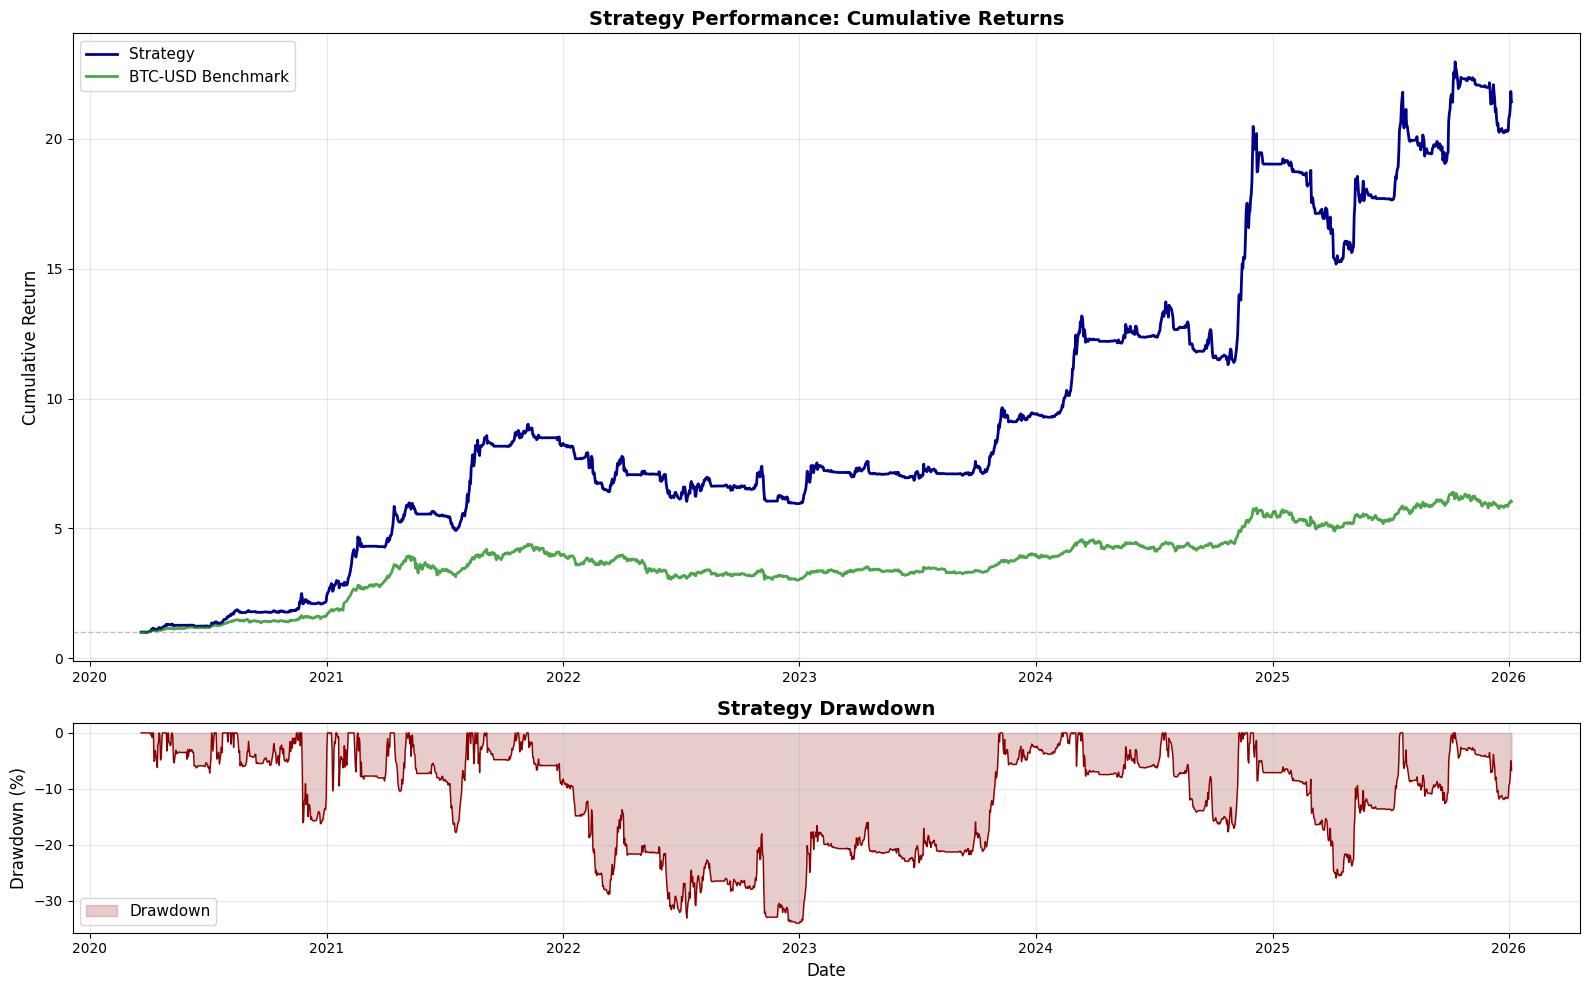

In [173]:
# Create strategy performance and drawdown plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot 1: Cumulative Returns (Equity Curve)
ax1.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, 
         linewidth=2, label='Strategy', color='darkblue')
ax1.plot(cumulative_portfolio_returns_benchmark.index, cumulative_portfolio_returns_benchmark, 
         linewidth=2, label='BTC-USD Benchmark', color='green', alpha=0.7)

ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.set_title('Strategy Performance: Cumulative Returns', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Plot 2: Drawdown
ax2.fill_between(drawdown.index, drawdown * 100, 0, 
                 color='darkred', alpha=0.2, label='Drawdown')
ax2.plot(drawdown.index, drawdown * 100, 
         linewidth=1, color='darkred')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_title('Strategy Drawdown', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

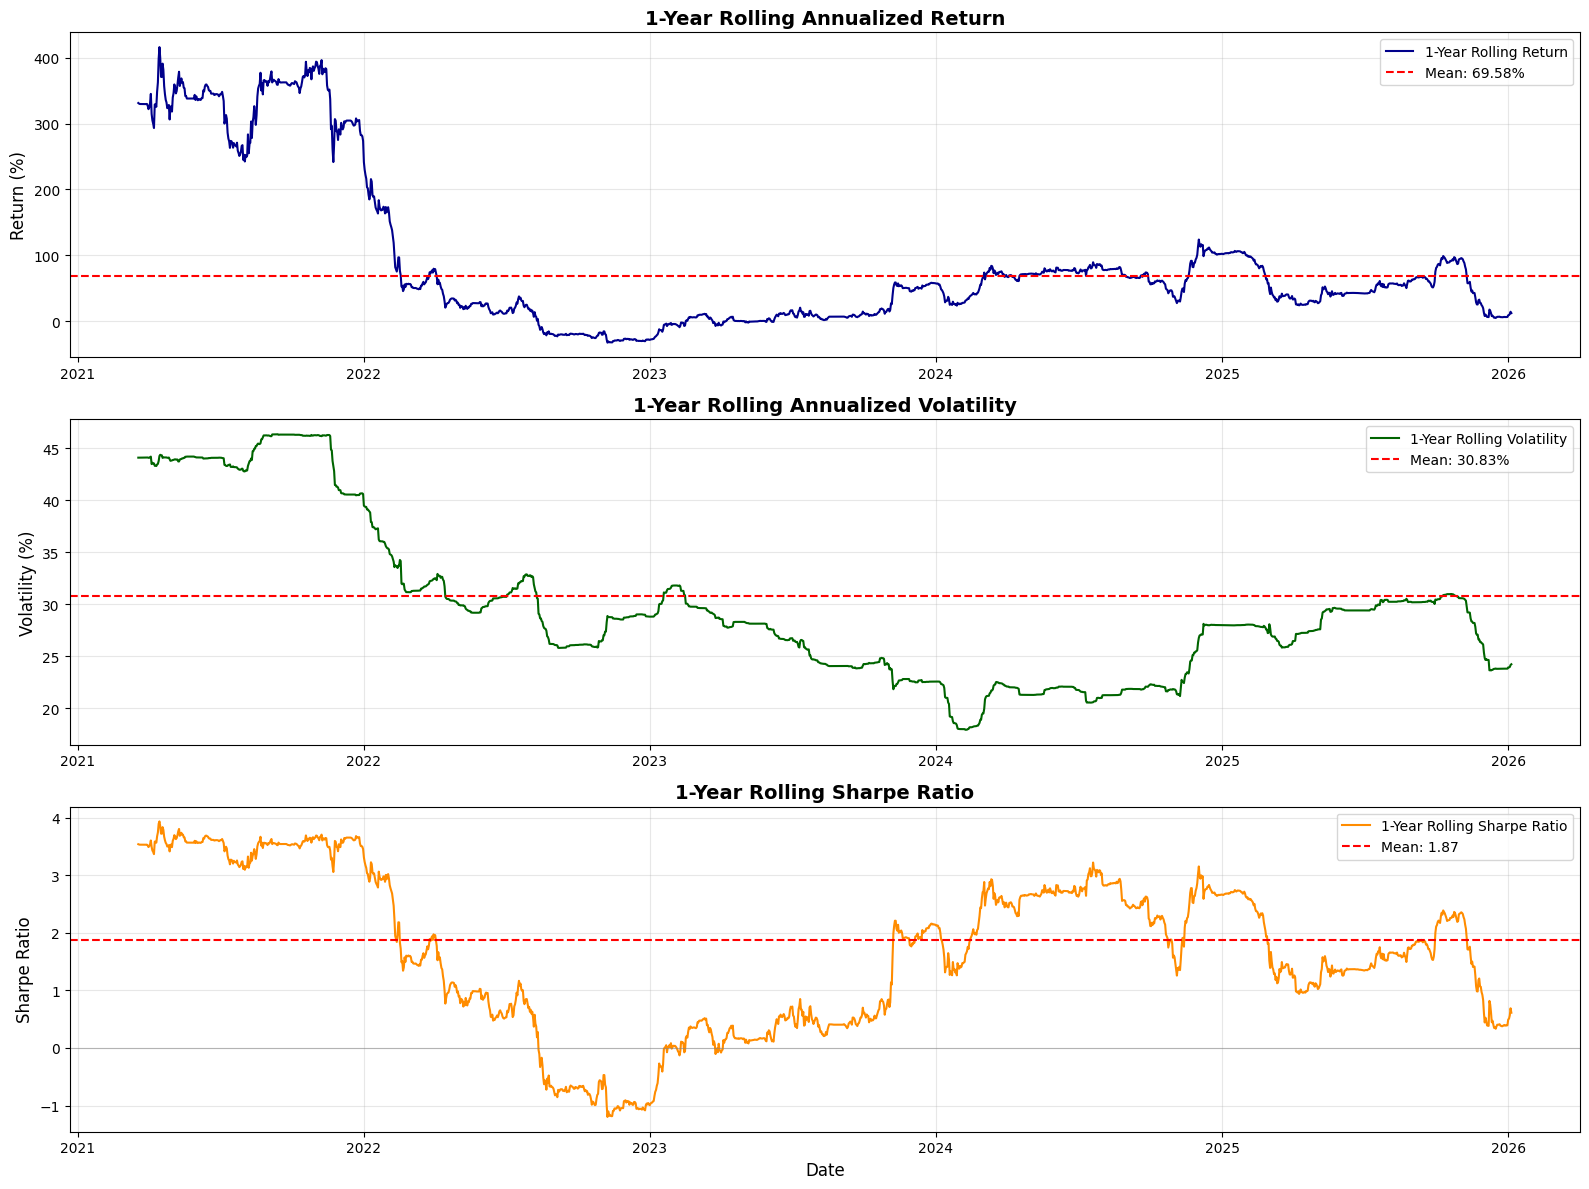

In [175]:
# Calculate 1-year rolling metrics for the strategy
rolling_window = 365  # 365 days = 1 year (crypto markets trade daily)

# 1-year rolling return (annualized)
rolling_return = portfolio_returns.rolling(window=rolling_window).apply(
    lambda x: (1 + x).prod() - 1
)

# 1-year rolling volatility (annualized)
rolling_vol = portfolio_returns.rolling(window=rolling_window).std() * np.sqrt(365)

# 1-year rolling Sharpe ratio
rolling_sharpe = (portfolio_returns.rolling(window=rolling_window).mean() / 
                  portfolio_returns.rolling(window=rolling_window).std()) * np.sqrt(365)

# Create the plots
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Rolling Return
ax1 = axes[0]
ax1.plot(rolling_return.index, rolling_return * 100, 
         linewidth=1.5, color='darkblue', label='1-Year Rolling Return')
ax1.axhline(y=annualized_return, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {annualized_return:.2f}%')
ax1.set_ylabel('Return (%)', fontsize=12)
ax1.set_title('1-Year Rolling Annualized Return', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling Volatility
ax2 = axes[1]
ax2.plot(rolling_vol.index, rolling_vol * 100, 
         linewidth=1.5, color='darkgreen', label='1-Year Rolling Volatility')
ax2.axhline(y=annualized_volatility, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {annualized_volatility:.2f}%')
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.set_title('1-Year Rolling Annualized Volatility', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe Ratio
ax3 = axes[2]
ax3.plot(rolling_sharpe.index, rolling_sharpe, 
         linewidth=1.5, color='darkorange', label='1-Year Rolling Sharpe Ratio')
ax3.axhline(y=sharpe_ratio, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {sharpe_ratio:.2f}')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Sharpe Ratio', fontsize=12)
ax3.set_title('1-Year Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()